In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm

## Portfolio Variance

In [2]:
fake_corr = np.array([[1.0, -0.6, -0.6], [-0.6, 1.0, -0.6], [-0.6, -0.6, 1.0]])
fake_corr

array([[ 1. , -0.6, -0.6],
       [-0.6,  1. , -0.6],
       [-0.6, -0.6,  1. ]])

In [53]:
sd = np.array([1, 1, 1])

In [54]:
sd * fake_corr * sd.T

array([[ 1. , -0.6, -0.6],
       [-0.6,  1. , -0.6],
       [-0.6, -0.6,  1. ]])

In [57]:
weights = np.array([0.0, 0.5, 0.5])

In [58]:
weights * D

array([[0.   , 0.   , 0.   ],
       [0.   , 0.125, 0.   ],
       [0.   , 0.   , 0.125]])

## Value at Risk

In [3]:
capital = 100
vol = 0.20
p = 0.99

VaR = capital * vol * np.sqrt(20 / 365) * norm.ppf(1-p)
VaR

-10.891136958200777

## Modified Duration (Zero Coupon Bond)

In [11]:
bond_price = 1000
bond_yield = 0.03

In [13]:
duration = 5 * (np.exp(-0.03 * 5))
duration

4.303539882125289

In [14]:
modified_duration = 5 * (np.exp(-0.04 * 5))
modified_duration

4.093653765389909

In [15]:
modified_duration = 5 * (np.exp(-0.02 * 5))
modified_duration

4.524187090179797

In [16]:
dollar_duration = 5 * (1000 * np.exp(-0.04 * 5) / 1001)
dollar_duration

4.089564201188721

In [17]:
dollar_duration = 5 * (1000 * np.exp(-0.04 * 5) / 999)
dollar_duration

4.097751516906816

In [19]:
1000 * 4.30 * 0.01

43.0

## Cumulative Hazard

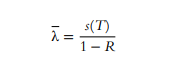

In [30]:
expected_loss = 0.65
yield_spread = 0.0060 # 60 Basis Points
yield_spread

0.006

In [31]:
L = yield_spread / (expected_loss)
L

0.00923076923076923

## Corporate Bonds

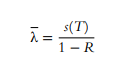

In [21]:
corporate = 0.08
risk_free = 0.06
recovery_rate = 0.40
yield_spread = 0.02 

In [23]:
L = yield_spread / (1 - recovery_rate)
L

0.03333333333333333

In [24]:
L**2

0.0011111111111111111

## Semi Annual Rating Matrix

### A. Calculate the 7 Month Transition Matrix

In [6]:
ratings = ['AAA','AA','A','BBB','BB','B','CCC','default']
transition= np.array([
    [90.81, 8.33, 0.68,0.06, 0.12, 0,0,0],
    [0.70,90.65,7.79,0.64,0.06,0.14,0.02,0],
    [0.09,2.27,91.05,5.52,0.74,0.26,0.01,0.06],
    [0.02,0.33,5.95,86.93,5.30,1.17,0.12,0.18],
    [0.03,0.14,0.67,7.73,80.53,8.84,1.00,1.06],
    [0,0.11,0.24,0.43,6.48,83.46,4.07,5.21],
    [0.22,0,0.22,1.30,2.38,11.24,64.86,19.78],
    [0,0,0,0,0,0,0,100]
]) / 100

print(sum(transition.transpose()))
transition_df = pd.DataFrame(transition, columns=ratings, index=ratings)
display(transition_df)

[1. 1. 1. 1. 1. 1. 1. 1.]


,AAA,AA,A,BBB,BB,B,CCC,default
AAA,0.9081,0.0833,0.0068,0.0006,0.0012,0.0000,0.0000,0.0000
AA,0.0070,0.9065,0.0779,0.0064,0.0006,0.0014,0.0002,0.0000
A,0.0009,0.0227,0.9105,0.0552,0.0074,0.0026,0.0001,0.0006
BBB,0.0002,0.0033,0.0595,0.8693,0.0530,0.0117,0.0012,0.0018
BB,0.0003,0.0014,0.0067,0.0773,0.8053,0.0884,0.0100,0.0106
B,0.0000,0.0011,0.0024,0.0043,0.0648,0.8346,0.0407,0.0521
CCC,0.0022,0.0000,0.0022,0.0130,0.0238,0.1124,0.6486,0.1978
default,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [7]:
from scipy.optimize import minimize

class split_transition_matrix():
    """compute the fractional transition matrix
    input the transition matrix, 
    the number of period into which the matrix is divded, 
    the function to minimize (usually least squares fit)
    """
    def __init__(self, transition_matrix, periods, fcn):
        self.m = transition_matrix
        self.p = periods
        self.t_vector = self.m.ravel()
        self.fcn = fcn

    def cumulate_matrix(self):
        self.t = np.reshape(self.t_vector, self.m.shape)
        self.t_cume = cumulate_transitions(self.t, self.p)

    def matrix_diff2(self, a, b):
        return sum(((a - b)*(a - b)).ravel())

    def matrix_vs_cume_diff2(self):
        self.cumulate_matrix()
        return self.matrix_diff2(self.m, self.t_cume)

    def matrix_min(self, t_vector):
        self.t_vector = self.fcn(t_vector)
        return self.matrix_vs_cume_diff2()
    
    def minimize(self):
        """
        compute the fractional multiple of the matrix by
        
        """
        self.res = minimize(self.matrix_min, self.m, method='Powell',tol=1e-10, options={'maxiter':100000})
        return self.res
        
    def get_sub_matrix(self):
        return np.reshape(self.fcn(self.res.x), self.m.shape)  
    
    def cumulate_sub_matrix(self):
        return pd.DataFrame(cumulate_transitions(self.get_sub_matrix(), self.p), index=ratings, columns=ratings)

def cumulate_transitions(t, p):
    """multiply the transition matrix p-times"""
    t_cume = t.copy()
    for i in range(p - 1):
        t_cume = t_cume.dot(t)
    return t_cume

def split_matrix(transition, ratings, periods, fcn):
    """create fractional matrix and display matrix and its fit to the original"""
    t_period = split_transition_matrix(transition, periods, fcn)
    res = t_period.minimize()
    print ('=' * 80)
    print("periods = ", t_period.p, "success = ", res.success, "function value = ",res.fun, 'message = ', res.message)
    display(pd.DataFrame(t_period.get_sub_matrix(), index=ratings, columns=ratings).round(5))
    cumulative_matrix = t_period.cumulate_sub_matrix()
    print("cumulative transition matrix")
    display(cumulative_matrix.round(5))
    print("deviation of cumulative from original transition matrix")
    display((t_period.m - cumulative_matrix).round(5))

    return t_period

In [8]:
def fcn2(x):
    """minimize the sum of squared values"""
    return pow(x, 2)

seven_month = split_matrix(transition, ratings, 7, fcn2)  # monthly

C:\Users\steve\AppData\Local\Temp\ipykernel_1268\2661492707.py:35: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  self.res = minimize(self.matrix_min, self.m, method='Powell',tol=1e-10, options={'maxiter':100000})


periods =  7 success =  True function value =  6.465190755216095e-08 message =  Optimization terminated successfully.


,AAA,AA,A,BBB,BB,B,CCC,default
AAA,0.98628,0.01293,0.00058,0.00004,0.00019,0.00000,0.00000,0.00000
AA,0.00108,0.98590,0.01207,0.00069,0.00003,0.00020,0.00003,0.00000
A,0.00013,0.00351,0.98632,0.00869,0.00096,0.00033,0.00000,0.00007
BBB,0.00003,0.00041,0.00938,0.97959,0.00876,0.00151,0.00013,0.00019
BB,0.00004,0.00019,0.00070,0.01286,0.96865,0.01487,0.00152,0.00117
B,0.00000,0.00016,0.00034,0.00022,0.01092,0.97355,0.00751,0.00730
CCC,0.00039,0.00000,0.00029,0.00218,0.00369,0.02071,0.93947,0.03330
default,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


cumulative transition matrix


,AAA,AA,A,BBB,BB,B,CCC,default
AAA,0.90810,0.08330,0.0068,0.0006,0.00119,0.00011,0.00001,0.00001
AA,0.00700,0.90650,0.0779,0.0064,0.00060,0.00139,0.00019,0.00007
A,0.00090,0.02270,0.9105,0.0552,0.00740,0.00260,0.00010,0.00060
BBB,0.00020,0.00330,0.0595,0.8693,0.05300,0.01170,0.00120,0.00180
BB,0.00030,0.00140,0.0067,0.0773,0.80530,0.08840,0.01000,0.01060
B,0.00007,0.00109,0.0024,0.0043,0.06480,0.83460,0.04070,0.05210
CCC,0.00219,0.00020,0.0022,0.0130,0.02380,0.11240,0.64860,0.19780
default,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,1.00000


deviation of cumulative from original transition matrix


,AAA,AA,A,BBB,BB,B,CCC,default
AAA,-0.00000,0.00000,0.0,0.0,0.00001,-0.00011,-0.00001,-0.00001
AA,0.00000,-0.00000,0.0,0.0,-0.00000,0.00001,0.00001,-0.00007
A,0.00000,0.00000,-0.0,-0.0,-0.00000,0.00000,-0.00000,0.00000
BBB,-0.00000,0.00000,-0.0,-0.0,-0.00000,-0.00000,0.00000,0.00000
BB,0.00000,0.00000,-0.0,-0.0,-0.00000,0.00000,0.00000,0.00000
B,-0.00007,0.00001,-0.0,-0.0,-0.00000,-0.00000,0.00000,0.00000
CCC,0.00001,-0.00020,0.0,0.0,0.00000,0.00000,-0.00000,0.00000
default,-0.00000,-0.00000,-0.0,-0.0,-0.00000,-0.00000,-0.00000,-0.00000


### B. Give a step by step process by which you would verify the five month and seven month transtion matrix are consitent with each other. 

#### In order to verify that two transiton matricies are consistent with each other I would compute both given the numerical routines from above. I would then compare the probabilites of default. The five month transition matrix should have smaller probabilites of downgrades and defaults because there is a lesser time horizon. The seven month transition matrix should have larger probabilities of downgrades and defaults because there is a greater time horizon. If this does not check out then the matricies are not consistent with each other. 

### C. What is the steady state distribution of ratings? 

#### The steady state is a transition state model that differentiates between the usual and extreme environments. The usual distribution will have smaller probabilites of downgrades and defaults compared to the extreme distribution. 